# Uncertainty Analysis Using GP, NLM, and BaCOUn

### Analysis of the paper: [BaCOUn: Bayesian Classifers with Out-of-Distribution Uncertainty](https://arxiv.org/pdf/2007.06096.pdf)



**Team Members:** Qiang Fei, Catharine Wu, Ruochen Zhao, Silin Zou

## Table of Contents

1. Problem Statement
2. Existing Work
3. Contribution
4. Data (Toy data + Mnist)
5. Experiments (GP, NLM, BaCOUn)
6. Evaluation and Interpretation
7. Future Work
8. References

In [21]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE

## 1. Problem Statement

Traditional classification models focus on producing highly confident models that fit the observed data perfectly, which results in high sensitivity toward data shifts. However, in high-risk domains, we’d like the models to only be confident when we have enough domain knowledge (abundant data) and provide appropriate uncertainty when we don’t so we know when to bring in human expertise to make effective decisions. In this project, we'll experiment different models on different types of data to explore model sensitivity and efficiency on providing uncertainties and distinguishing between aleatoric uncertainty and epistemic uncertainty.

## 2. Existing Work

## TODO

## 3. Contribution

## TODO

## 4. Data Generation

In this section, we'll generate different types of datasets with different out-of-distribution (OOD) shapes.

### 4.1. Well-Seperated and Linearly-Seperable

Here, we are insterested in exploring the effect of different OOD shapes on linearly-seperable data.

In [22]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

In [23]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

#### a) ODD: complete ring

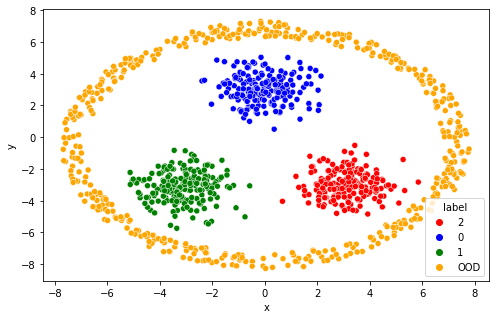

In [24]:
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a = df1a.append(df1a_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

#### b) OOD: semicircle

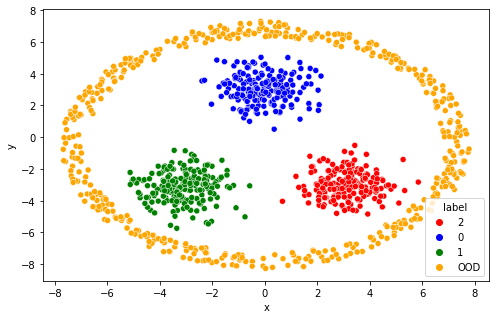

In [25]:
df1b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1b = df1b.append(df1b_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

#### c) Incomplete OOD (w/ holes)

In [26]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
angles = np.random.uniform(0,2 * np.pi, 50)

for _ in range(500):
    # random angle
    angle = np.random.choice(angles)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

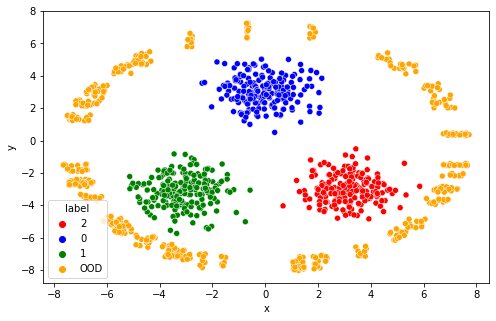

In [27]:
df1c = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1c_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD')).sample(500, random_state = 0)
df1c = df1c.append(df1c_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1c, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

### 4.2. Well-Seperated and Linearly-Seperable, but clusters are far away from each other

We are interested in exploring whether the points in between far-away clusters should be considered as OOD.

In [28]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 6], [-6, -6], [6, -6]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

#### a) one ODD boundary
Between-cluster points are not OOD.

In [29]:
# generate OOD
np.random.seed(0)
r = 11.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-1+(r + random.random())*np.sin(angle))

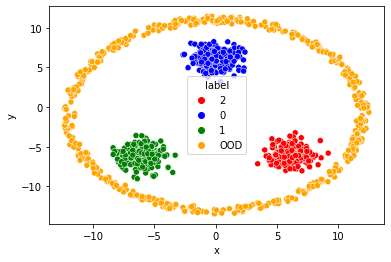

In [30]:
df2a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2a = df2a.append(df2a_ood, ignore_index=True)

sns.scatterplot(data=df2a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

#### b) three ODD boundary
Between-cluster points are OOD.

In [31]:
# generate OOD
np.random.seed(42)
r = 3.5 # radius
cx1, cx2, cx3 = 0, -6, 6
cy1, cy2, cy3 = 6, -6, -6
x1, x2 = [], []
for _ in range(500//3):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(cx1 + (r + random.random())*np.cos(angle))
    x1.append(cx2 + (r + random.random())*np.cos(angle))
    x1.append(cx3 + (r + random.random())*np.cos(angle))
    x2.append(cy1 + (r + random.random())*np.sin(angle))
    x2.append(cy2 + (r + random.random())*np.sin(angle))
    x2.append(cy3 + (r + random.random())*np.sin(angle))

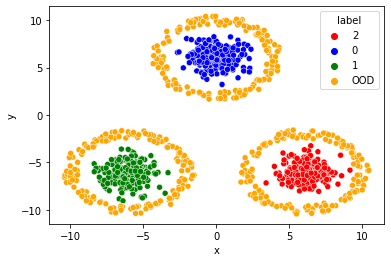

In [32]:
df2b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2b = df2b.append(df2b_ood, ignore_index=True)

sns.scatterplot(data=df2b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

### 4.3. Not Well-Seperated
Here we explore the effect of overlapping clusters.

In [33]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 1], [-1, -1], [1, -1]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

In [34]:
# generate OOD
np.random.seed(42)
r = 4.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

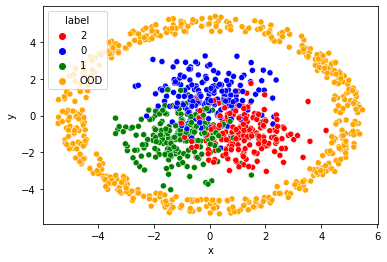

In [35]:
df3 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df3_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df3 = df3.append(df3_ood, ignore_index=True)

sns.scatterplot(data=df3, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

### 4.4. Well-Seperated by non-linear boundary

In [36]:
X, y = datasets.make_moons(n_samples=600, shuffle=True, noise=0.1, random_state=0)

In [37]:
# generate OOD
np.random.seed(0)
r = 2 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(.5+(r + random.random())*np.cos(angle))
    x2.append(.3+(r + random.random())/1.5*np.sin(angle))

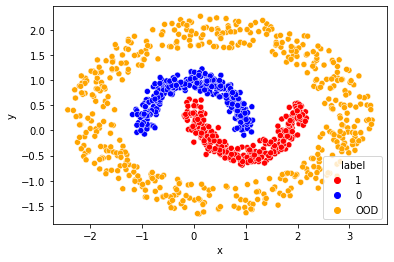

In [38]:
df4 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df4_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df4 = df4.append(df4_ood, ignore_index=True)

sns.scatterplot(data=df4, x="x", y="y", hue="label", palette=["red", "blue", "orange"]);

### 4.5. MNIST
Now we use a real dataset: MNIST, we take samples from digits 0,1,2 as in-distribution data, and sample from the digit 3 as OOD.

In [39]:
# Load data from https://www.openml.org/d/554
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

In [40]:
# Pick out 3 classes of digits: 0, 1, 2 and take a subset of samples as in-distribution points
X_0, y_0 = X[(y == '0')][:500], y[(y == '0')][:500].astype(int)
X_1, y_1 = X[(y == '1')][:500], y[(y == '1')][:500].astype(int)
X_2, y_2 = X[(y == '2')][:500], y[(y == '2')][:500].astype(int)
# sample from digit 3 as OODs
X_ood, y_ood = X[(y == '3')][:500], ['OOD'] * 500

In [41]:
len(np.concatenate((X_0, X_1, X_2)))

1500

In [42]:
# combine data
X_mnist = np.concatenate((X_0, X_1, X_2, X_ood))
y_mnist = np.concatenate((y_0, y_1, y_2, y_ood))

Visualize the data in two dimensions (TSNE)

In [43]:
vis_df = pd.DataFrame(X_mnist)
vis_df['y'] = y_mnist

tsne_results = TSNE(n_components=2, random_state=207).fit_transform(X_mnist)

vis_df['tsne-2d-one'] = tsne_results[:,0]
vis_df['tsne-2d-two'] = tsne_results[:,1]

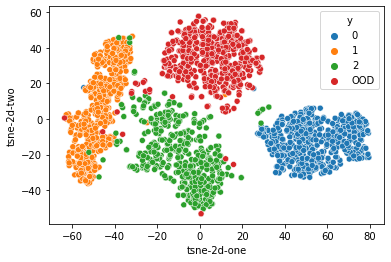

In [44]:
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y", data=vis_df, legend="full");

## 5. Experiment

### 5.1 Gaussian Processes (GP)

In [45]:
#define the gaussian process model

def gaussian(df, kernel, title, n_restarts_optimizer=10, alpha=0.1, l = 16):
    start = time.time()
    #first get train x and train y (without including OOD data)
    train_df = df[df.label!='OOD']
    train_y = train_df.label.values
    train_x = train_df.drop(columns = ['label']).values
    #initialize model
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, alpha=alpha, 
                                        normalize_y=True)
    model.fit(train_x, train_y)
    params = model.kernel_.get_params()
    #predict with OOD data
    whole_y = df.label.replace('OOD', -1).values
    whole_x = df.drop(columns = ['label']).values
    y_pred, std = model.predict(whole_x, return_std=True)
    
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    #plot the predictions
    df_new = pd.DataFrame(dict(x=whole_x[:,0], y=whole_x[:,1], label=y_pred))
    sns.scatterplot(data=df_new, x="x", y="y", hue="label", ax = ax[0]);
    
    #Plot the uncertainties
    x = np.linspace(-l,l,1000).reshape(-1,1)
    y = np.linspace(-l,l,1000).reshape(-1,1)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((1000,1000))

    for i in range(1000):
        xy = np.concatenate((X[i].reshape(-1,1), Y[i].reshape(-1,1)), axis = 1)
        y_pred_new, std_new = model.predict(xy, return_std=True)
        Z[i] = std_new

    ax[1].pcolormesh(X, Y, Z, shading='gouraud', vmin=Z.min(), vmax=Z.max())
    ax[1].scatter(df[df.label==0].x, df[df.label==0].y, color = 'blue')
    ax[1].scatter(df[df.label==1].x, df[df.label==1].y, color = 'green')
    ax[1].scatter(df[df.label==2].x, df[df.label==2].y, color = 'red')
    ax[1].scatter(df[df.label=='OOD'].x, df[df.label=='OOD'].y, color = 'yellow')
    ax[0].set_title('{} predictions'.format(title))
    ax[1].set_title('{} uncertainties'.format(title))
    print('execution time: {} mins'.format((time.time()-start)/60))
    return model, ax

Testing case 1a

execution time: 0.41615958213806153 mins
execution time: 0.6445787191390991 mins
execution time: 0.3615922013918559 mins


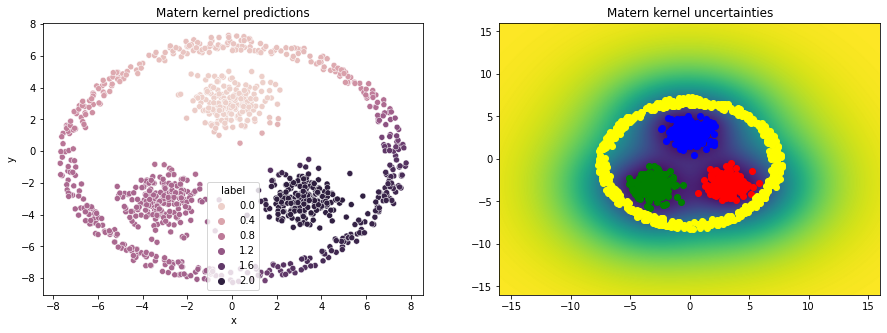

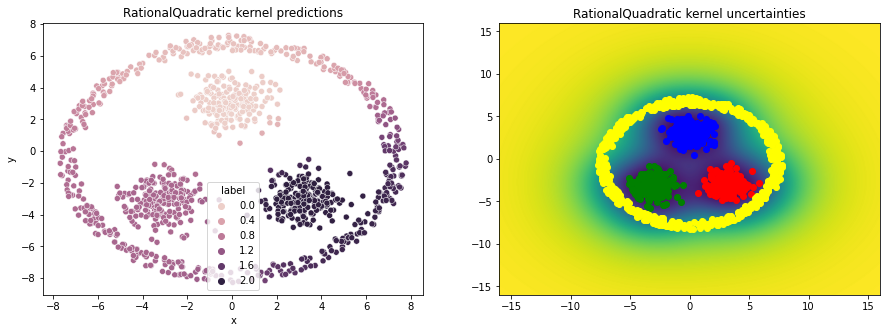

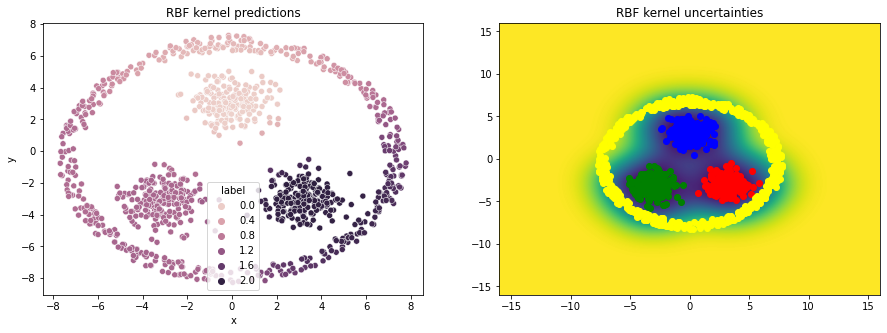

In [47]:
#df1: abc
#df2: ab
#df3, df4
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1a1, ax1 = gaussian(df1a, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model1a2, ax2 = gaussian(df1a, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax3 = gaussian(df1a, kernel3, 'RBF kernel')
plt.show()

execution time: 0.3616172671318054 mins
execution time: 0.3621933341026306 mins
execution time: 0.3669012983640035 mins


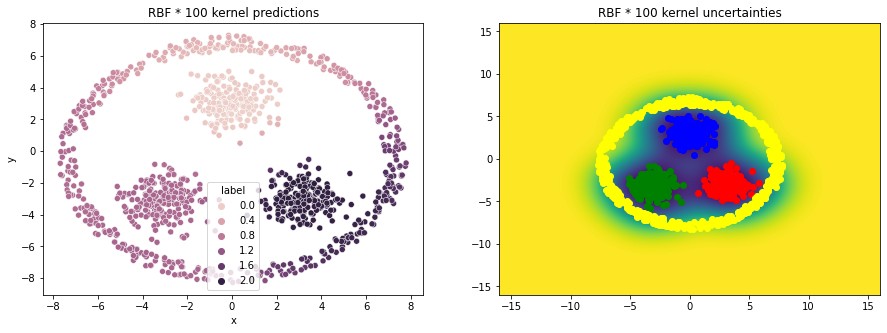

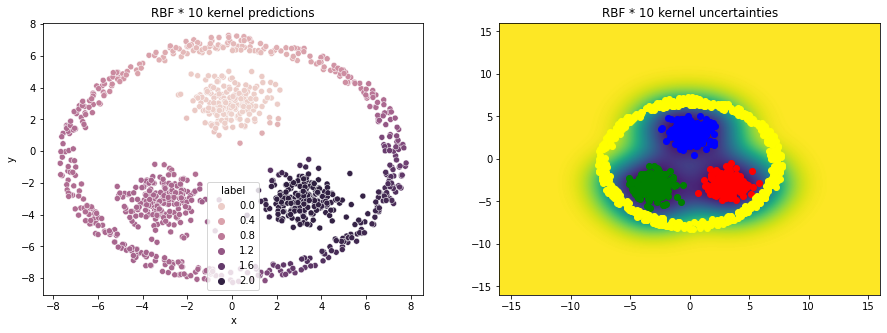

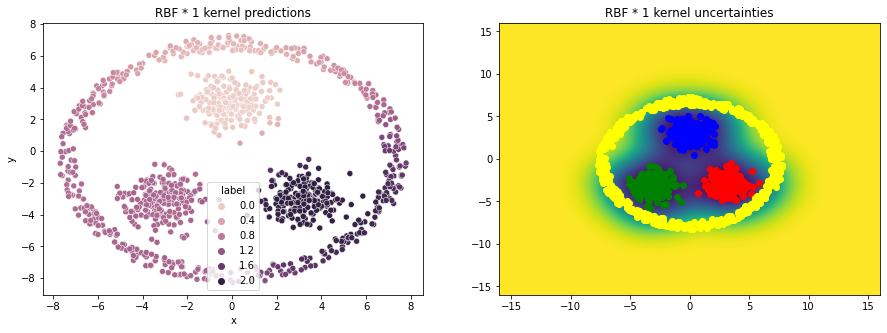

In [48]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(100.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a1, ax1 = gaussian(df1a, kernel1, 'RBF * 100 kernel')
kernel2 = gp.kernels.ConstantKernel(10.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax2 = gaussian(df1a, kernel2, 'RBF * 10 kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax3 = gaussian(df1a, kernel3, 'RBF * 1 kernel')
plt.show()

execution time: 0.3327407201131185 mins
execution time: 0.38081498543421427 mins
execution time: 1.008454179763794 mins


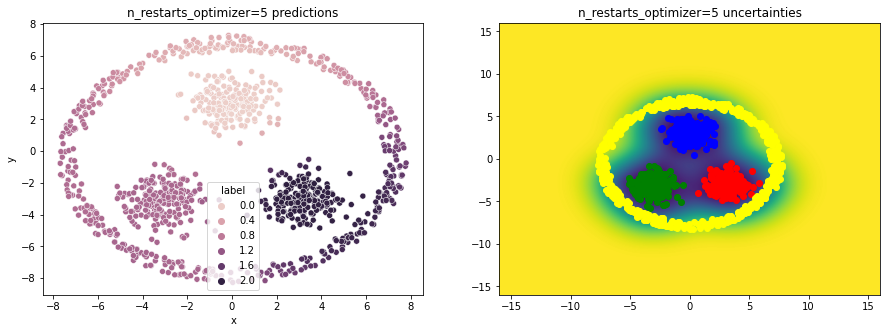

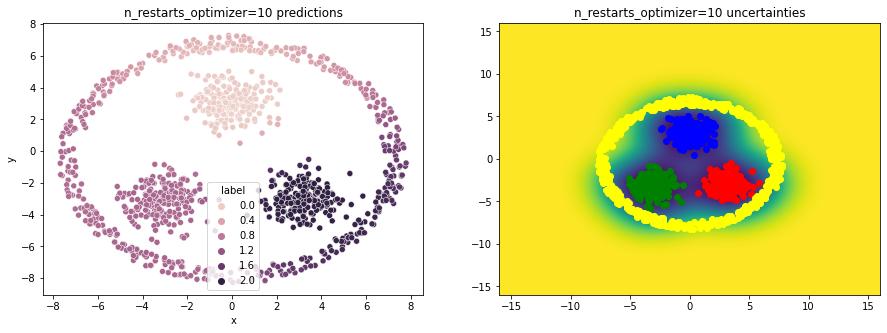

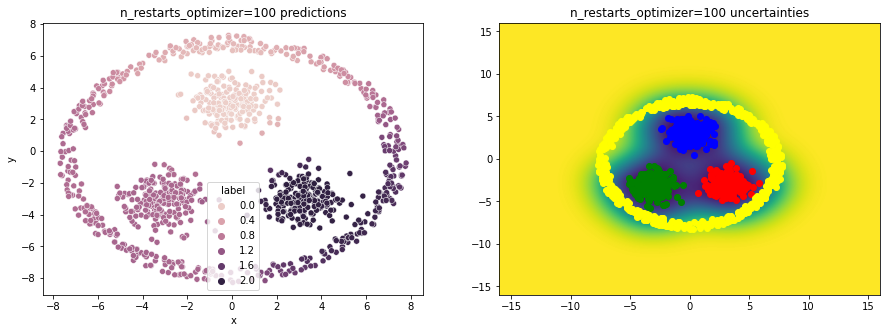

In [49]:
#adjust n_start optimizer parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a1, ax1 = gaussian(df1a, kernel1, 'n_restarts_optimizer=5', n_restarts_optimizer=5)
model1a2, ax2 = gaussian(df1a, kernel1, 'n_restarts_optimizer=10', n_restarts_optimizer=10)
model1a2, ax3 = gaussian(df1a, kernel1, 'n_restarts_optimizer=100', n_restarts_optimizer=100)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


execution time: 0.365062415599823 mins
execution time: 0.35667043129603065 mins
execution time: 0.35031845172246295 mins


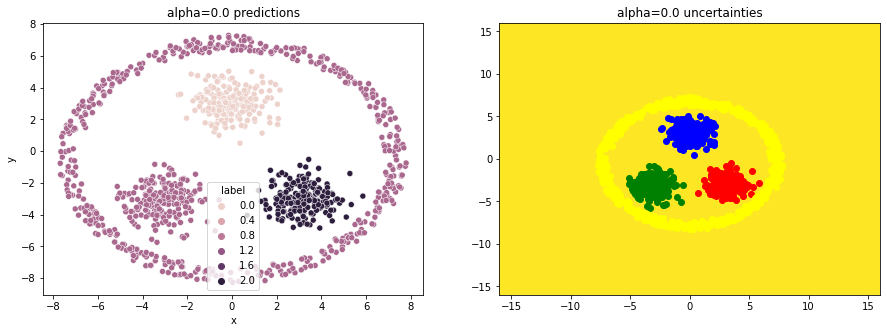

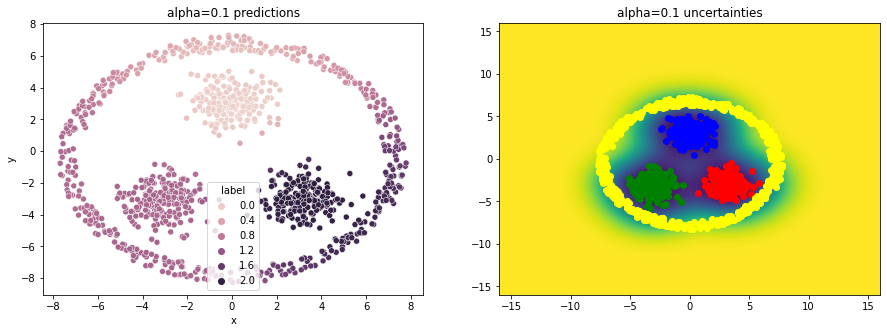

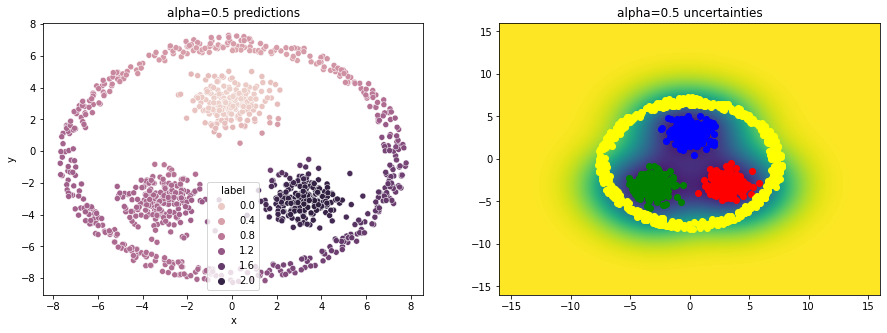

In [50]:
#adjust alpha parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))

model1a1, ax1 = gaussian(df1a, kernel1, 'alpha=0.0', alpha=0.0)
model1a2, ax2 = gaussian(df1a, kernel1, 'alpha=0.1', alpha=0.1)
model1a2, ax3 = gaussian(df1a, kernel1, 'alpha=0.5', alpha=0.5)
plt.show()

Testing case 1b

execution time: 0.40151776870091754 mins
execution time: 0.6958925485610962 mins
execution time: 0.37779528299967446 mins


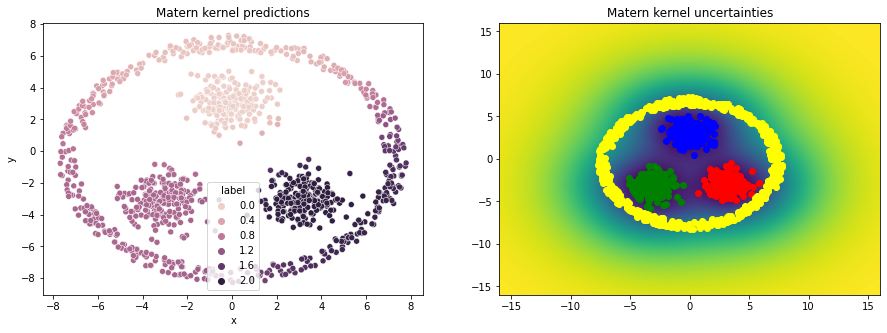

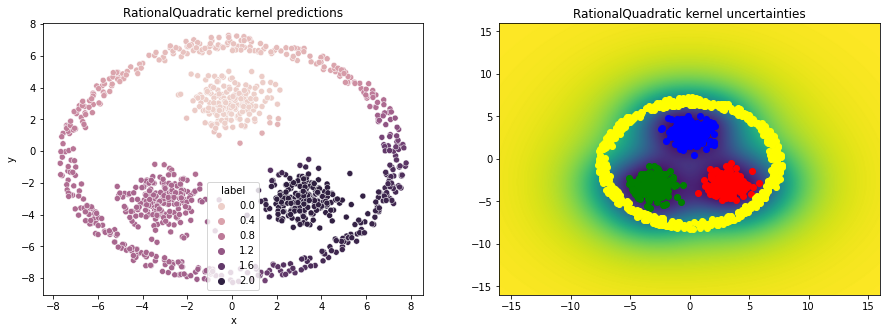

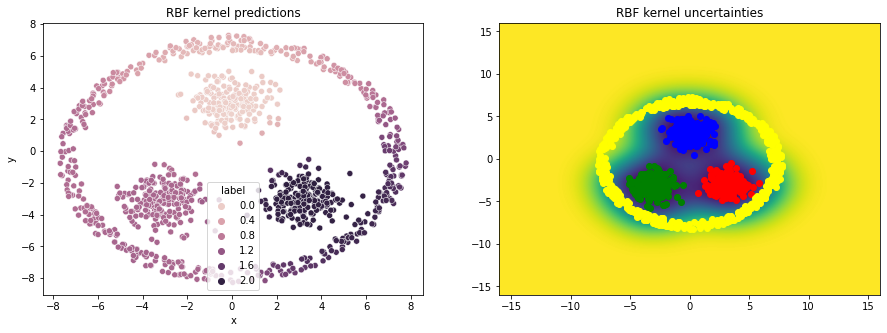

In [51]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1b1, ax1 = gaussian(df1b, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model1b2, ax2 = gaussian(df1b, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1b2, ax3 = gaussian(df1b, kernel3, 'RBF kernel')
plt.show()

Testing case 1c

execution time: 0.39856120347976687 mins
execution time: 0.6279167691866557 mins
execution time: 0.3550785660743713 mins


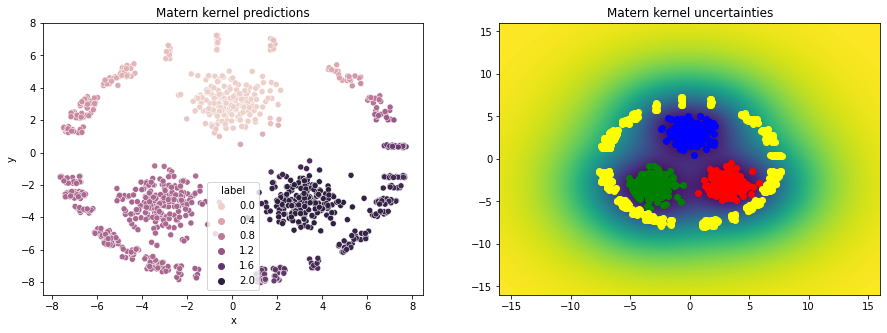

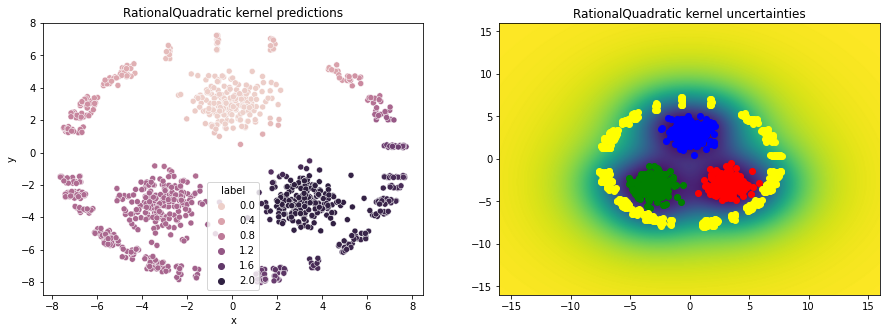

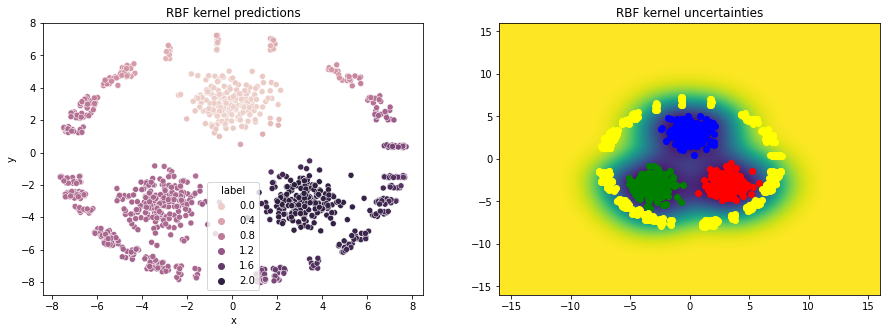

In [52]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1c1, ax1 = gaussian(df1c, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model1c2, ax2 = gaussian(df1c, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1c2, ax3 = gaussian(df1c, kernel3, 'RBF kernel')
plt.show()

Testing case 2a

execution time: 0.44277668396631875 mins
execution time: 0.7286454359690349 mins
execution time: 0.3521746277809143 mins


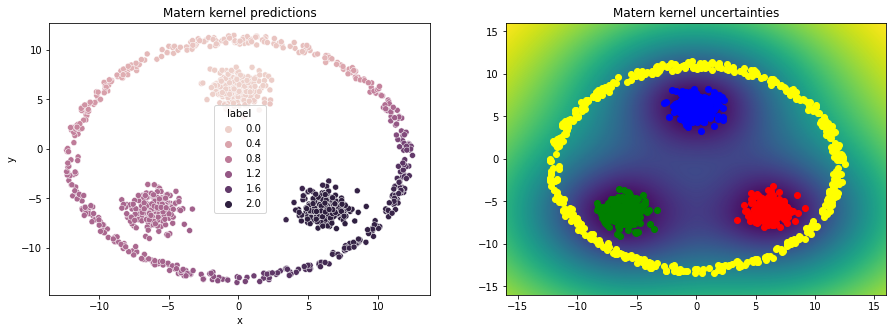

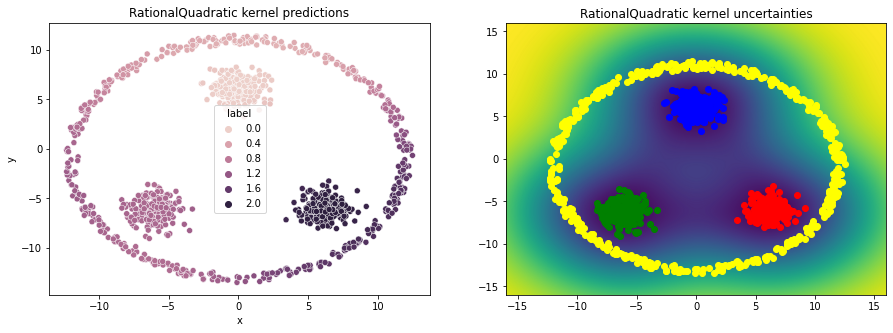

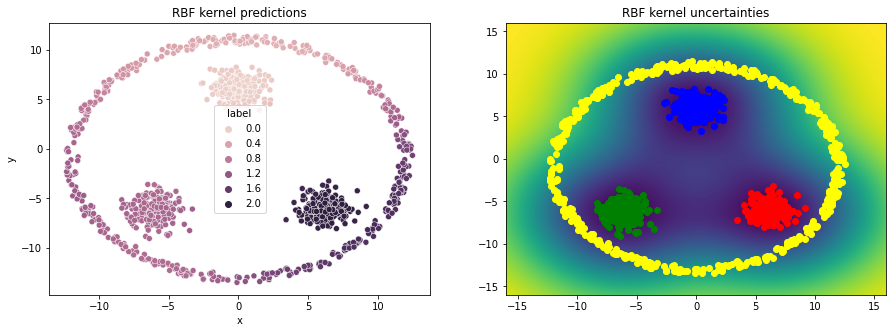

In [53]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model2a1, ax1 = gaussian(df2a, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model2a2, ax2 = gaussian(df2a, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model2a3, ax3 = gaussian(df2a, kernel3, 'RBF kernel')
plt.show()

Testing case 2b

execution time: 0.402774182955424 mins
execution time: 0.7278555631637573 mins
execution time: 0.35442525148391724 mins


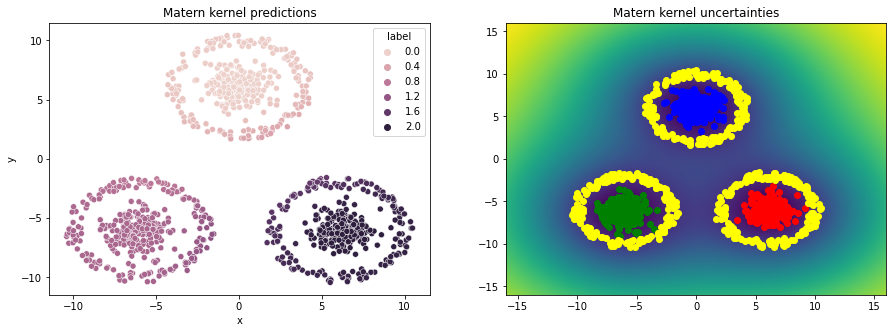

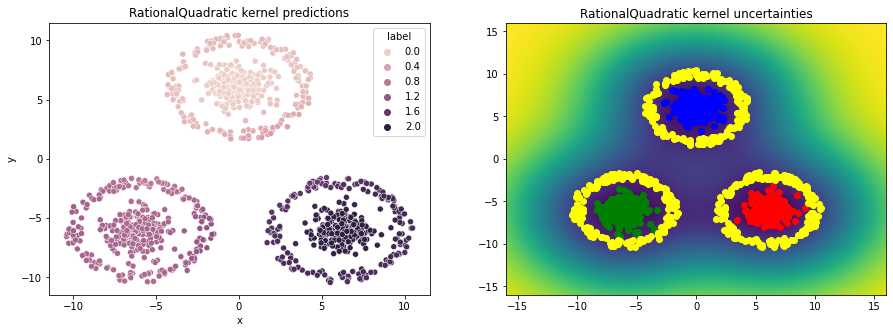

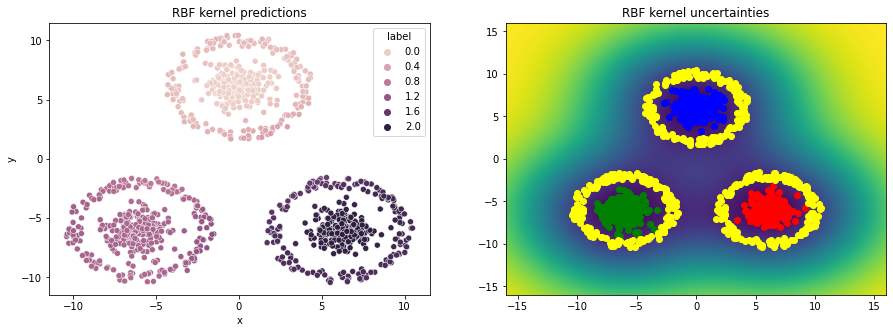

In [54]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model2b1, ax1 = gaussian(df2b, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model2b2, ax2 = gaussian(df2b, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model2b2, ax3 = gaussian(df2b, kernel3, 'RBF kernel')
plt.show()

Testing case 3

execution time: 0.3411176562309265 mins
execution time: 0.5959040522575378 mins
execution time: 0.4687310854593913 mins


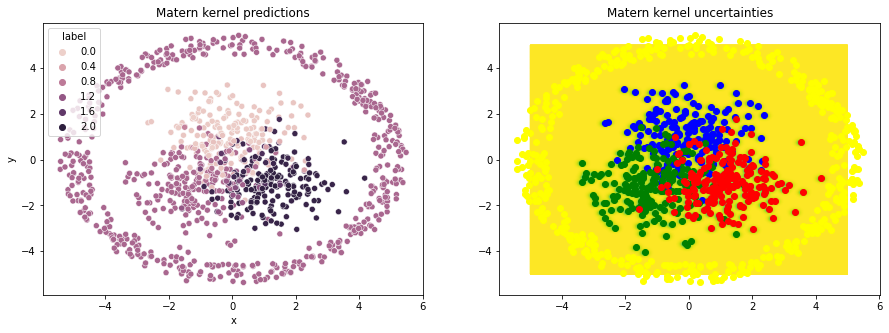

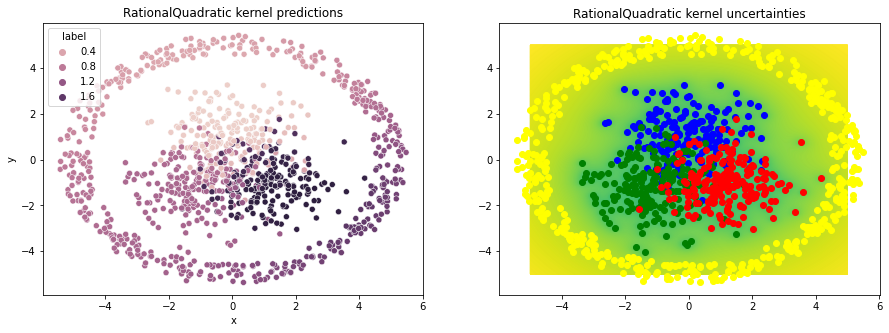

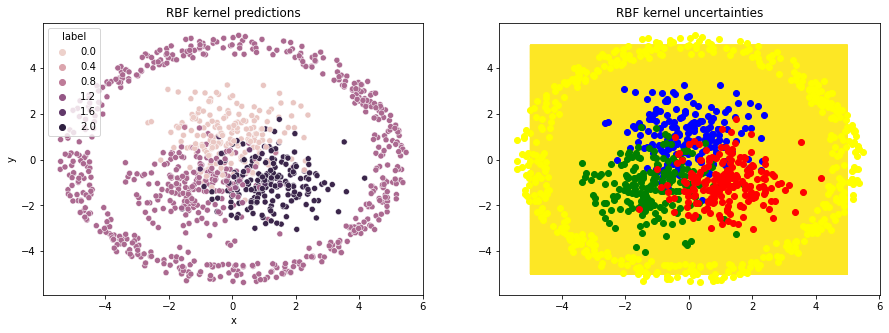

In [57]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model31, ax1 = gaussian(df3, kernel1, 'Matern kernel', l = 5)
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model32, ax2 = gaussian(df3, kernel2, 'RationalQuadratic kernel', l = 5)
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model32, ax3 = gaussian(df3, kernel3, 'RBF kernel', l = 5)
plt.show()

Testing case 4

execution time: 0.4161352356274923 mins
execution time: 0.6875594814618429 mins
execution time: 0.35697518587112426 mins


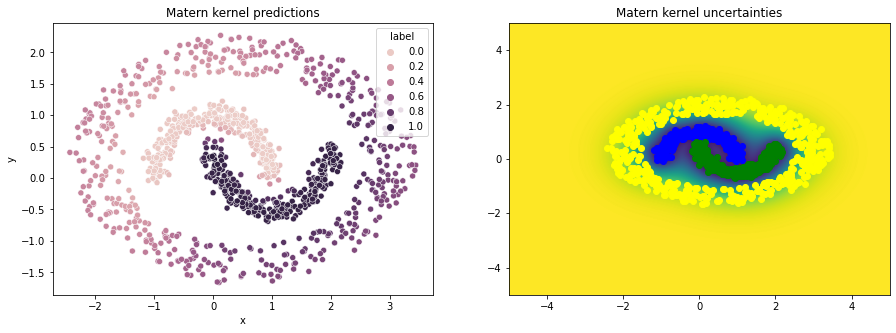

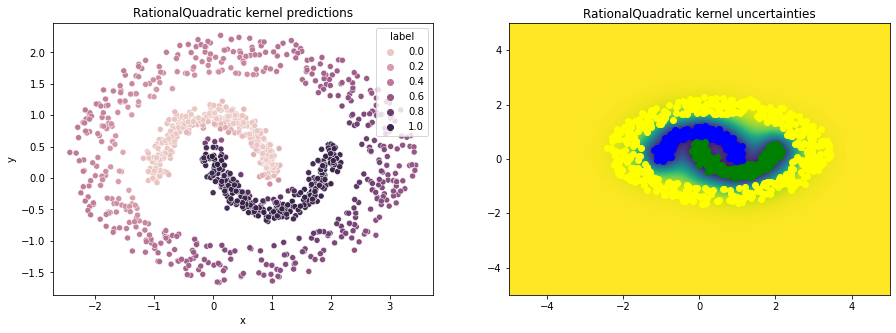

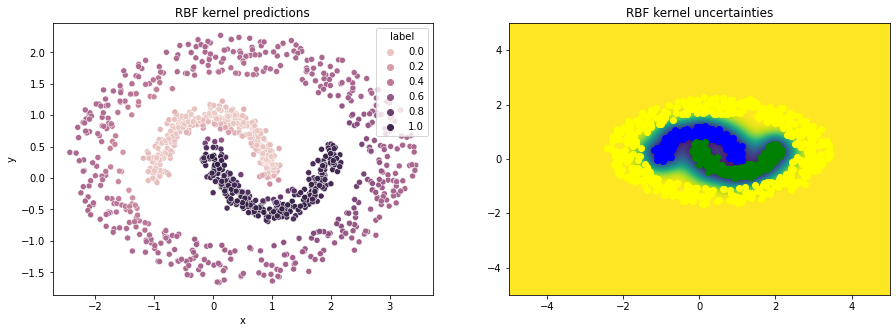

In [56]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model41, ax1 = gaussian(df4, kernel1, 'Matern kernel', l = 5)
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model42, ax2 = gaussian(df4, kernel2, 'RationalQuadratic kernel', l = 5)
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model42, ax3 = gaussian(df4, kernel3, 'RBF kernel', l = 5)
plt.show()

Testing the MNIST case

In [72]:
def gaussian_MNIST(kernel, title, n_restarts_optimizer=10, alpha=0.1, l = 16):
    start = time.time()
    #first get train x and train y (without including OOD data)
    X_train = np.concatenate((X_0, X_1, X_2))
    y_train = np.concatenate((y_0, y_1, y_2))
    #initialize model
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, alpha=alpha, 
                                        normalize_y=True)
    model.fit(X_train, y_train)
    params = model.kernel_.get_params()
    #predict with OOD data
    y_pred, std = model.predict(X_mnist, return_std=True)
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    #plot the predictions
    df_new = pd.DataFrame(dict(x=tsne_results[:,0], y=tsne_results[:,1], label=y_pred))
#     sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="y", data=vis_df, legend="full");
    sns.scatterplot(data=df_new, x="x", y="y", hue="label", ax = ax[0]);
        
    df = pd.DataFrame(dict(x=tsne_results[:,0], y=tsne_results[:,1], label=std))
    sns.scatterplot(data=df, x="x", y="y", hue="label", ax = ax[1]);
    ax[0].set_title('{} predictions'.format(title))
    ax[1].set_title('{} uncertainties'.format(title))
    print('execution time: {} mins'.format((time.time()-start)/60))
    return model, ax

(2000,)
(2000,)
execution time: 2.4340366164843243 mins
(2000,)
(2000,)
execution time: 4.774819564819336 mins
(2000,)
(2000,)
execution time: 2.2799840688705446 mins


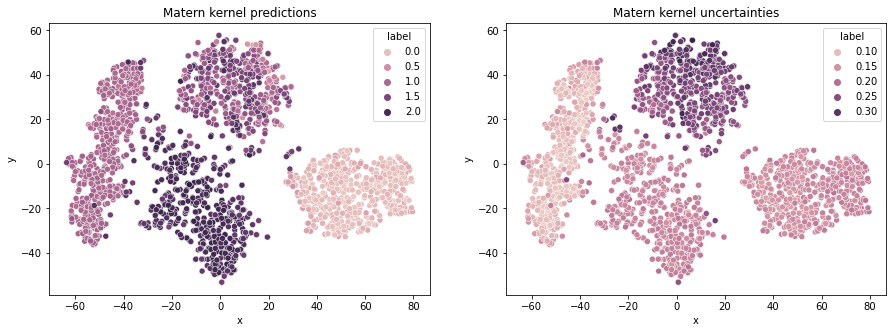

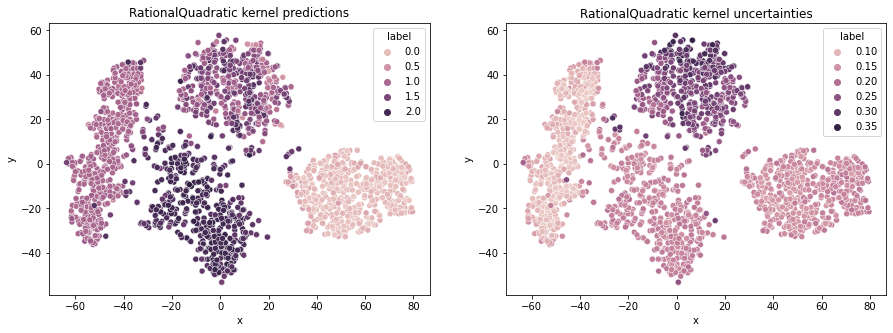

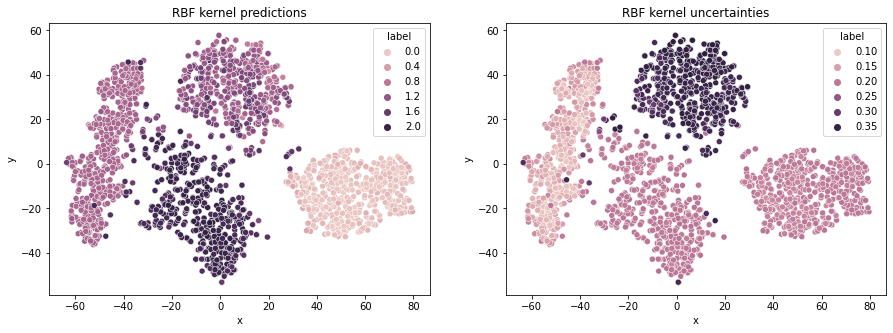

In [73]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model51, ax1 = gaussian_MNIST(kernel1, 'Matern kernel', l = 60)
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model52, ax2 = gaussian_MNIST(kernel2, 'RationalQuadratic kernel', l = 5)
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model53, ax3 = gaussian_MNIST(kernel3, 'RBF kernel', l = 5)
plt.show()

### 5.2 Neural Linear Models (NLM)

### 5.3 Bayesian Classifers with Out-of-Distribution Uncertainty (BaCOUn)

## 6. Evaluation and Interpretation

### 6.1 Gaussian Processes (GP)

### 6.2 Neural Linear Models (NLM)

### 6.3 Bayesian Classifers with Out-of-Distribution Uncertainty (BaCOUn)

## 7. Future Work

## 8. References